In [101]:
from astropy.io import ascii,fits
from astropy import wcs
from astropy.table import vstack, Table
import numpy as np
import glob
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM,z_at_value,Planck15
import pickle

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.05)

In [102]:
zPrompt = np.linspace(0.01,3,100)
RIaPromptGround = pickle.load(open("sndtd/GroundRIa.pkl","rb")) # fp ~ 0.6  
RIaPromptHubble = pickle.load(open("sndtd/HubbleRIa.pkl","rb")) # fp ~ 0.2 

In [103]:
RIa = ascii.read(open("RIa_Strolger2020.csv","rb"))
RIa[:5]
RIaBinned = ascii.read(open("RIaBinned_Strolger2020.csv","rb"))

uppers,lowers = [],[]
for i in RIa['Stat.Uncertainty']:
    uppers.append(float(i.split('_')[0]))
    lowers.append(float(i.split('_')[1]))
stat_uncertainties = np.array([lowers,uppers])
np.shape(stat_uncertainties)

uppers,lowers = [],[]
for i in RIaBinned['Stat.Uncertainty']:
    uppers.append(float(i.split('_')[0]))
    lowers.append(float(i.split('_')[1]))
Binned_stat_uncertainties = np.array([lowers,uppers])
np.shape(Binned_stat_uncertainties)

zbins,zuncertainties = [],[]
for i in RIaBinned['Redshift']:
    zbins.append(float(i.split('_+-')[0]))
    zuncertainties.append(float(i.split('_+-')[1]))

def fRIa(z):
    R0 = 0.247*10**(-4) # pm .002
    if z <= 1.0:
        A = 1.5 # pm .02
        return R0*(1+z)**A
    elif z > 1.0:
        # power law broken arbitrarily at z ~ 1 but continuous
        z1=1
        c = R0*(1+z1)**(1.5+0.1)
        A = -0.1 # pm 0.2
        return c*(1+z)**A#c+R0*(1+z)**A

def efRIa(z,pm):
    R0 = 0.247*10**(-4) # pm .002
    upperR0 = R0 + 0.002*10**(-4)
    lowerR0 = R0 - 0.002*10**(-4)
    A1 = 1.5 # pm .02
    upperA1 = A1 + 0.02
    lowerA1 = A1 - 0.02
    if z <= 1.0:
        upperRIa = upperR0*(1+z)**upperA1
        lowerRIa = lowerR0*(1+z)**lowerA1
    elif z > 1.0:
        # power law broken arbitrarily at z ~ 1 but continuous
        A2 = -0.1 # pm 0.2
        upperA2 = A2 + 0.2 
        lowerA2 = A2 - 0.2
        z1=1 # threshold
        upperC = upperR0*(1+z1)**(upperA1+upperA2)
        lowerC = lowerR0*(1+z1)**(lowerA1+lowerA2)
        upperRIa = upperC*(1+z)**upperA2
        lowerRIa = lowerC*(1+z)**lowerA2
    if pm == 'p':
        # upper
        return upperRIa
    elif pm == 'm':
        # lower
        return lowerRIa

zs = np.arange(0,2.5,0.01)
Rfunc = np.array([fRIa(i) for i in zs])
upperRfuncs = np.array([efRIa(i,'p') for i in zs])
lowerRfuncs = np.array([efRIa(i,'m') for i in zs])

Rstar = fRIa(1.75)
N = 10 # was 20
sigma = np.sqrt(N)
# R propto N , uncertainty in N ~ poisson ~ sqrt(N)
fracUncertainty = np.sqrt(N)/N
print(fracUncertainty)
uncertaintyRstar = fracUncertainty*Rstar

0.31622776601683794


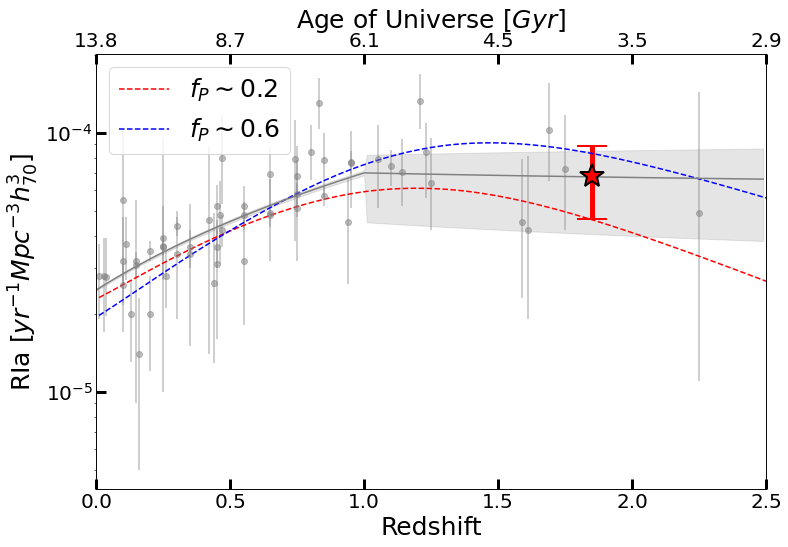

In [104]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,8))
matplotlib.rcParams.update({'font.size': 25,'xtick.labelsize':20,'ytick.labelsize':20})

# various rate measurements
ax.errorbar(RIa['Redshift'],RIa['RIa']*10**(-4),yerr=stat_uncertainties*10**(-4),fmt='o',color='grey',alpha=0.5)

binned = False
if binned:
    # binned 
    ax.errorbar(zbins,RIaBinned['RIa']*10**(-4),xerr=zuncertainties,yerr=Binned_stat_uncertainties*10**(-4),
                fmt='^',color='black',alpha=0.75,markersize=10)

# JW gives 20 Ia detections between z ~ 1.5,2 --> fractional 0.22 stat uncertainty 
z = 1.85 #2
ax.errorbar(z,Rstar,yerr=uncertaintyRstar,fmt='*',color='red',mec='black',markersize=25,mew='2',elinewidth=5,capsize=15,capthick=5)

# Rodney's 2014 Prompt Ia model
ax.plot(zPrompt,RIaPromptHubble(zPrompt)*10**(-4),color='red',label=r'$ f_P \sim 0.2 $',linestyle='--')
ax.plot(zPrompt,RIaPromptGround(zPrompt)*10**(-4),color='blue',label=r'$ f_P \sim 0.6 $',linestyle='--')
ax.legend()

# plot Lou's broken power law
ax.plot(zs,Rfunc,color='grey')

# shade regions of lower and upper uncertainty for power law
ax.fill_between(zs,lowerRfuncs,upperRfuncs,color='grey',alpha=0.2)#plt.fill_between(x, y-error, y+error)


ax.set_xlabel("Redshift")
ax.set_ylabel("RIa [$yr^{-1} Mpc^{-3} h^3_{70}$]")
ax.set_yscale('log')

# put lookback times onto top axis lined up with redshifts
#ax2 = ax.twinx()
ax.set_xlim(0,2.5)
ax3 = ax.twiny()

new_tick_locations = np.arange(0,3.0,0.5) #np.arange(0,2.5,0.5) 
Universe_age = 13.77
new_tick_labels = [Universe_age - cosmo.lookback_time(i).value for i in new_tick_locations] 
new_tick_labels = [np.round(i,1) for i in new_tick_labels]

ax3.set_xlabel('Age of Universe [$Gyr$]')
ax3.set_xlim(ax.get_xlim())
ax3.set_xticks(new_tick_locations)
ax3.set_xticklabels(new_tick_labels)

# tick mark stuff, sizes, in/out of plot
ax.tick_params(length=10,width=3,direction='in')
ax3.tick_params(length=10,width=3,direction='in')

# only go up to 2.5

plt.savefig('RIa_logscale.pdf',bbox_inches='tight')

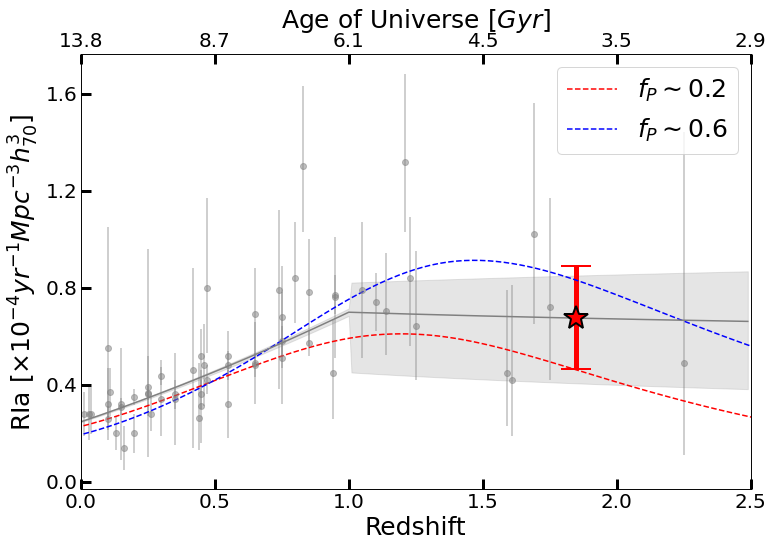

In [105]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(12,8))
matplotlib.rcParams.update({'font.size': 25,'xtick.labelsize':20,'ytick.labelsize':20})

# various rate measurements
ax.errorbar(RIa['Redshift'],RIa['RIa'],yerr=stat_uncertainties,fmt='o',color='grey',alpha=0.5)

binned = False
# binned 
if binned:
    ax.errorbar(zbins,RIaBinned['RIa'],xerr=zuncertainties,yerr=Binned_stat_uncertainties,
                fmt='^',color='black',alpha=0.75,markersize=10)

# JW gives 20 Ia detections between z ~ 1.5,2 --> fractional 0.22 stat uncertainty 
z = 1.85 #2
ax.errorbar(z,Rstar/(10**-4),yerr=uncertaintyRstar/(10**-4),fmt='*',color='red',mec='black',markersize=25,mew='2',elinewidth=5,capsize=15,capthick=5)

# Rodney's 2014 Prompt Ia model
ax.plot(zPrompt,RIaPromptHubble(zPrompt),color='red',label=r'$ f_P \sim 0.2 $',linestyle='--')
ax.plot(zPrompt,RIaPromptGround(zPrompt),color='blue',label=r'$ f_P \sim 0.6 $',linestyle='--')
ax.legend()

# plot Lou's broken power law
ax.plot(zs,Rfunc/(10**-4),color='grey')

# shade regions of lower and upper uncertainty for power law
ax.fill_between(zs,lowerRfuncs/(10**-4),upperRfuncs/(10**-4),color='grey',alpha=0.2)#plt.fill_between(x, y-error, y+error)

ax.set_xlabel("Redshift")
ax.set_ylabel(r"RIa [$ \times 10^{-4} yr^{-1} Mpc^{-3} h^3_{70}$]")

# put lookback times onto top axis lined up with redshifts
#ax2 = ax.twinx()
ax.set_xlim(0,2.5)
ax3 = ax.twiny()

new_tick_locations = np.arange(0,3.0,0.5) 
Universe_age = 13.77
new_tick_labels = [Universe_age - cosmo.lookback_time(i).value for i in new_tick_locations]  
new_tick_labels = [np.round(i,1) for i in new_tick_labels]

ax3.set_xlabel('Age of Universe [$Gyr$]')
ax3.set_xlim(ax.get_xlim())
ax3.set_xticks(new_tick_locations)
ax3.set_xticklabels(new_tick_labels)

# tick mark stuff, sizes, in/out of plot
ax.tick_params(length=10,width=3,direction='in')
ax3.tick_params(length=10,width=3,direction='in')

# too many y ticks
ax.set_yticks([0,0.4,0.8,1.2,1.6])


plt.savefig('RIa.pdf',bbox_inches='tight')

##  Type Ia supernova volumetric rate measures from various sources in the literature shown as grey points. The solid grey lines show a broken power-law fit to the data in redshift space \citet{Strolger et al. 2020}. The red star shows the projected constraints on the SN Ia rate measurement which could be achieved with this survey. The statistical uncertainty shown is from the expected detections of 20 $\pm$ 7 SNe Ia in the range, $ 1.5 \lessapprox z \lessapprox 2.0 $, \citet{Foley et al. 2018}. It is comparable to the statistical uncertainty from binning all 7 rate measurements over redshift range $z \sim 1.2, 2.25$. The dashed curves show fits to the data from a model which is convolving cosmic star formation history with a Ia DTD with two available channels \citet{Rodney et al. 2014}. The red dashed curve is fitting high-z data from Hubble surveys, the yellow dashed curve is fitting all the ground based data dominated by $z < 1$. The two channels are prompt, characterized as $f_P$, the total fraction of Ia which explodes within $ 500 Myr $ of formation; and afterwards all remaining following an inverse time law. The high-z measurements can more easily identify prompt SNe due to the larger star formations at these epochs. Although the uncertainties are large out at these high-z due to low detection numbers, there still seems to be some mild tension, with the possibility of much fewer prompt SNe at these earlier cosmic times. Improving the precision of this measurement could have a big impact on the design of the Roman SNIa survey.  If this JWST program finds that fp=0.2 or 0.3 then a high-z emphasis in the Roman design will be much less fruitful.

1.9971488091320637
1.7429278634760994


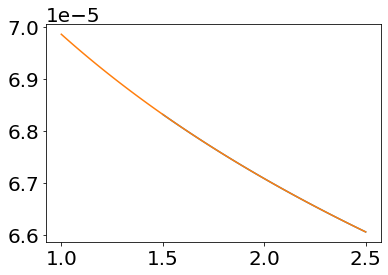

In [106]:
def meanz(zrange,model):
    tmp = []
    tmp2 = 0
    for i in range(len(zrange)):
        zi = zrange[i]
        ratei = model(zi)
        tmp.append(ratei)
        tmp2 += zi*ratei
    avgz = tmp2/np.sum(tmp)
    return avgz

zrange = np.linspace(1.5,2.5,100)
JWRIa = [fRIa(i) for i in zrange]
plt.plot(zrange,JWRIa)
print(meanz(zrange,fRIa))

zrange = np.linspace(1,2.5,100)
JWRIa = [fRIa(i) for i in zrange]
plt.plot(zrange,JWRIa)
print(meanz(zrange,fRIa))

In [107]:
"""
how many SNe would you expect to be discovered in 160 arcmin^2 over the course of one year

cosmo.angular_diameter_distance: This gives the proper (sometimes called 'physical') transverse
distance corresponding to an angle of 1 radian for an object
at redshift ``z``.
"""
import scipy.integrate as integrate

FoV_radsq = 160*(1/60)**2*(np.pi/180)**2 # arcmin^2 * [deg/arcmin]^2 * [rad/deg]^2
angle = np.sqrt(2)*np.sqrt(FoV_radsq) # treat the FoV as square, true for webb nircam 
print(angle,"rad")

0.005203566467437575 rad


In [108]:
# angular diameter distance between objects at two redshifts z2>z1
zbinvols = []
rzs = [] # /mpc^3/yr
nzs = [] # /yr
zs = np.arange(1,2.5,0.001)
for i in range(len(zs)):
    z1 = zs[i]
    z2 = zs[i]+0.001
    Rz1 = fRIa(z1)
    rzs.append(Rz1)
    DA = cosmo.angular_diameter_distance(z1) # Mpc transverse physical size of object 1 radian at z
    DA *= angle # 3.7x10^-3 rad ~ FoV on the fields 
    DAz1z2 = cosmo.angular_diameter_distance_z1z2(z1,z2) # Mpc distance between two redshifts 
    vol = (DA.value)**2*(DAz1z2.value)
    zbinvols.append(vol)
    Nz1 = Rz1*vol
    nzs.append(Nz1)
Ntot = 1.1*np.sum(nzs)
Ntot

5.835610433801871